In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/maximo_inclinado.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1422 non-null   float64
 1   A_x     53 non-null     float64
 2   A_y     53 non-null     float64
 3   B_x     52 non-null     float64
 4   B_y     52 non-null     float64
 5   C_x     51 non-null     float64
 6   C_y     51 non-null     float64
 7   D_x     52 non-null     float64
 8   D_y     52 non-null     float64
 9   E_x     50 non-null     float64
 10  E_y     50 non-null     float64
 11  F_x     54 non-null     float64
 12  F_y     54 non-null     float64
dtypes: float64(13)
memory usage: 144.6 KB


In [4]:
df = df[df.drop(columns='t').notna().any(axis=1)]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 0 to 1421
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       312 non-null    float64
 1   A_x     53 non-null     float64
 2   A_y     53 non-null     float64
 3   B_x     52 non-null     float64
 4   B_y     52 non-null     float64
 5   C_x     51 non-null     float64
 6   C_y     51 non-null     float64
 7   D_x     52 non-null     float64
 8   D_y     52 non-null     float64
 9   E_x     50 non-null     float64
 10  E_y     50 non-null     float64
 11  F_x     54 non-null     float64
 12  F_y     54 non-null     float64
dtypes: float64(13)
memory usage: 34.1 KB


In [6]:
def remove_flat_start(df, tolerance=0.05, min_points=5):
    pos = df.iloc[:, 1].values

    for i in range(1, len(pos) - min_points):
        window = pos[i:i + min_points]
        diffs = abs(window - pos[0])
        if (diffs > tolerance).any():
            return df.iloc[i:].reset_index(drop=True)

    return df.iloc[0:0]

def normalize_time(df):
    df = df.copy()
    df['t'] = df['t'] - df['t'].iloc[0]
    return df

def merge_position_tables(tables):
    merged = []
    for table in tables:
        temp = table.copy()
        temp.columns = ['t', 'x', 'y']
        merged.append(temp)
    return pd.concat(merged, ignore_index=True)

In [7]:
letters = sorted(set(col.split('_')[0] for col in df.columns if '_' in col))

df_list = [
    df[['t', f'{letter}_x', f'{letter}_y']].dropna()
    for letter in letters
]

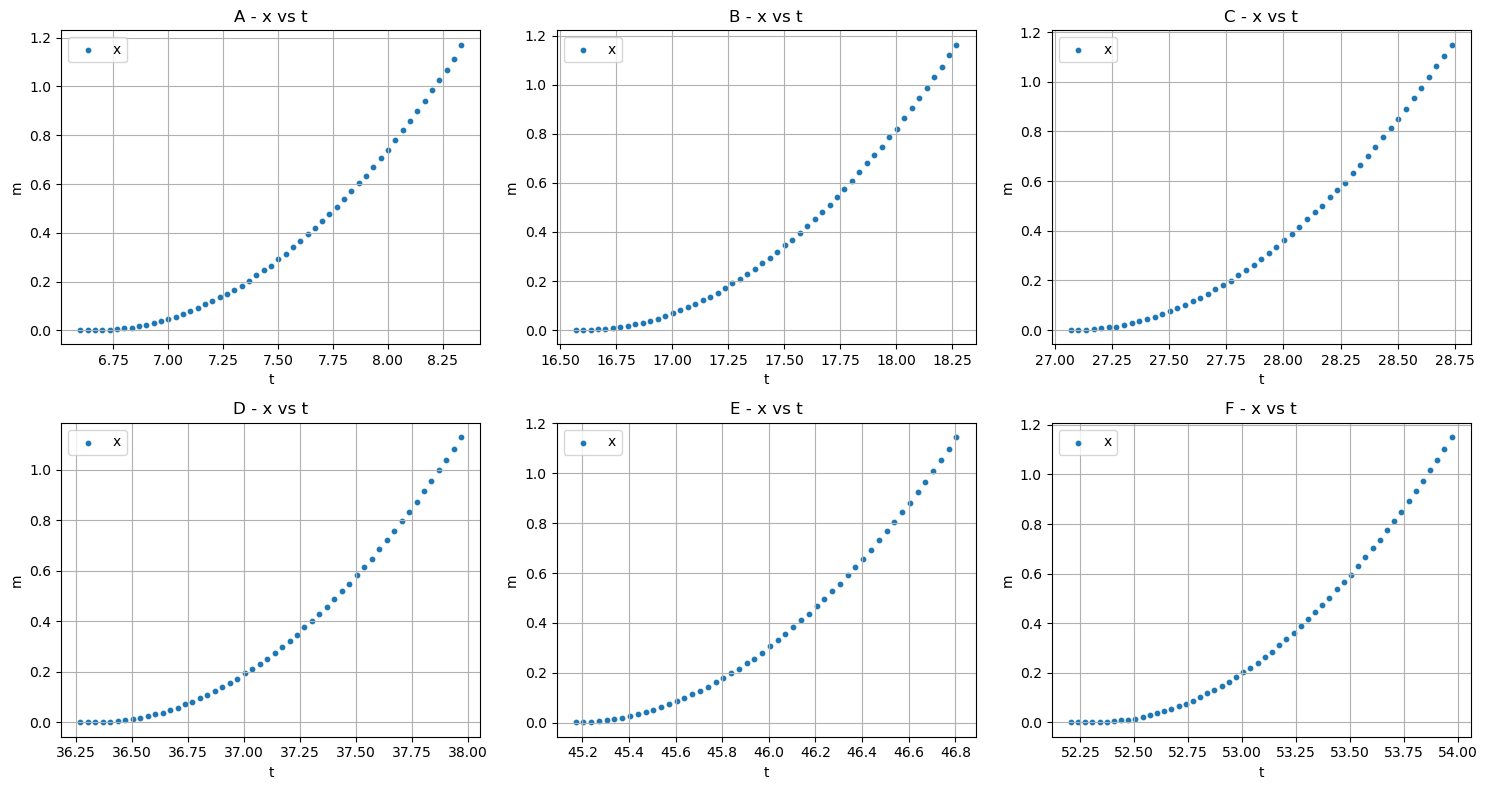

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i, df in enumerate(df_list):
    t = df['t']
    x_col = df.columns[1]
    y_col = df.columns[2]
    label = x_col.split('_')[0]

    axs[i].scatter(t, df[x_col], s=10, label='x')
    axs[i].set_title(f'{label} - x vs t')
    axs[i].set_xlabel('t')
    axs[i].set_ylabel('m')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [9]:
filtered_df_list = []

for df in df_list:
    df_cut = remove_flat_start(df, tolerance=0.01, min_points=5)
    if not df_cut.empty:
        df_norm = normalize_time(df_cut)
        filtered_df_list.append(df_norm)

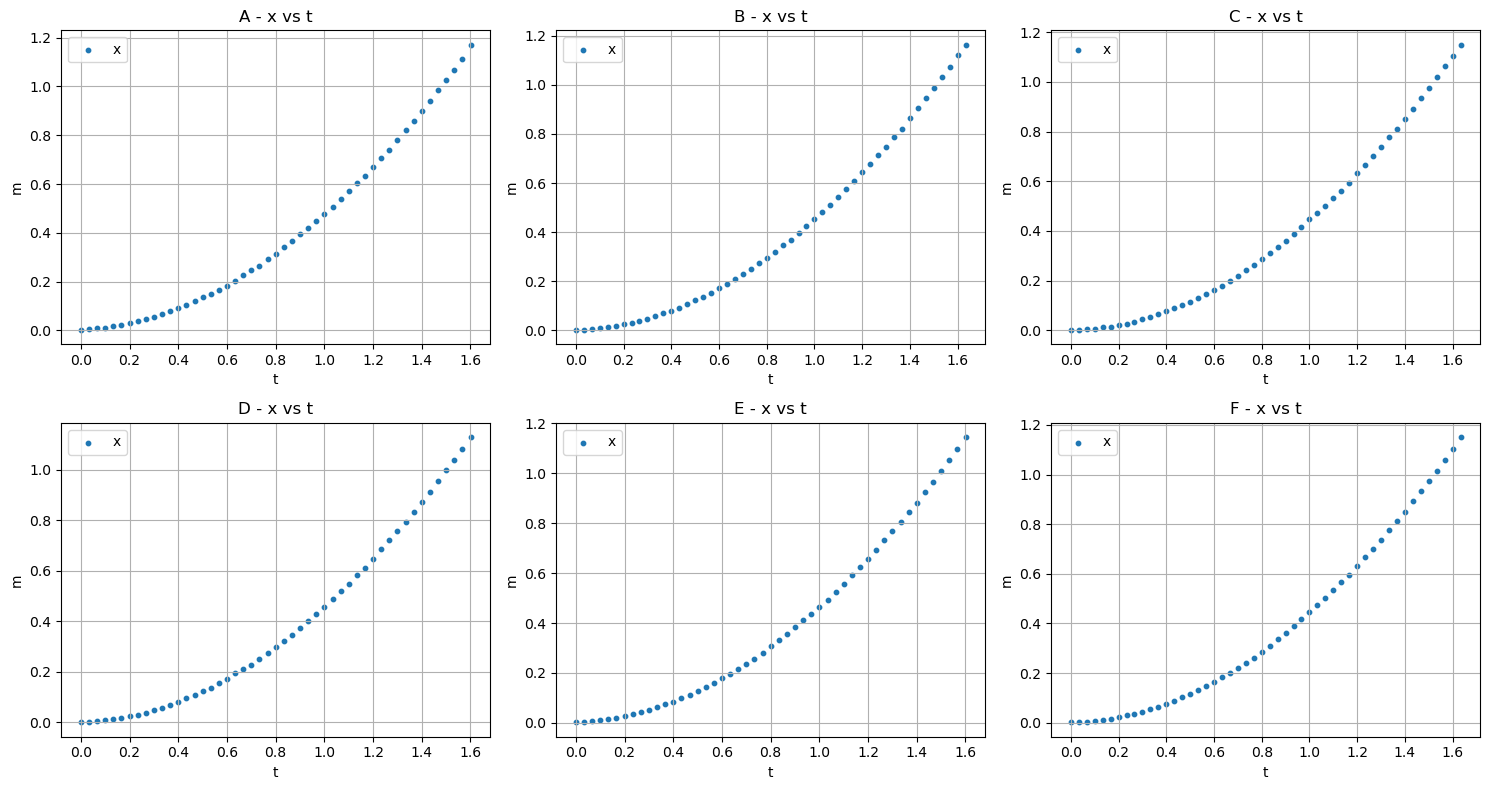

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i, df in enumerate(filtered_df_list):
    t = df['t']
    x_col = df.columns[1]
    y_col = df.columns[2]
    label = x_col.split('_')[0]

    axs[i].scatter(t, df[x_col], s=10, label='x')
    axs[i].set_title(f'{label} - x vs t')
    axs[i].set_xlabel('t')
    axs[i].set_ylabel('m')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [11]:
merged_df = merge_position_tables(filtered_df_list)

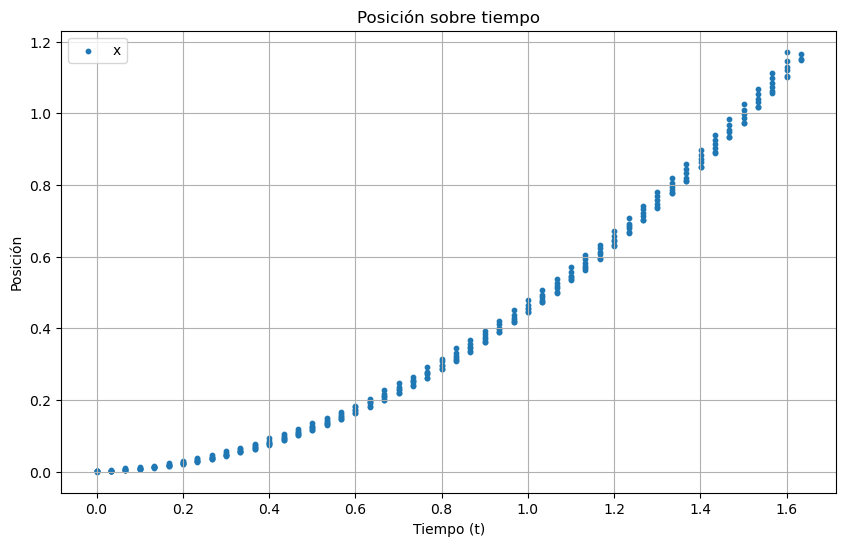

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['t'], merged_df['x'], s=10, label='x')

plt.xlabel('Tiempo (t)')
plt.ylabel('Posición')
plt.title('Posición sobre tiempo')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Constantes
g = 9.776
theta_deg = 1.4
theta_rad = np.radians(theta_deg)
delta_theta_rad = np.radians(0.5)
delta_t = 1 / 30

In [14]:
# Redondear el tiempo
merged_df['t_rounded'] = merged_df['t'].round(1)
grouped = merged_df.groupby('t_rounded')

summary = {
    't': [],
    'x_mean': [],
    'std': [],
    'sem_magnitude': []
}

# Incertidumbres fijas por instrumento (en metros)
delta_x_tracker = 1.664 / 1920
delta_x_angle = 0.038

# Suma en cuadratura de errores sistemáticos fijos
systematic_uncertainty = delta_x_tracker**2 + delta_x_angle**2

for t, group in grouped:
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()

    # SEM estadístico del conjunto
    distances = ((group['x'] - x_mean)**2 + (group['y'] - y_mean)**2).pow(0.5)
    sem = distances.std(ddof=1) / np.sqrt(5)

    # Total: SEM + errores fijos, en cuadratura
    total_uncertainty = np.sqrt(sem**2 + systematic_uncertainty)

    summary['t'].append(t)
    summary['x_mean'].append(x_mean)
    summary['std'].append(sem)
    summary['sem_magnitude'].append(total_uncertainty)

summary_df = pd.DataFrame(summary)

In [15]:
summary_df

,t,x_mean,std,sem_magnitude
0,0.0,0.001847,0.000465,0.038013
1,0.1,0.008979,0.000862,0.038020
2,0.2,0.024490,0.001558,0.038042
3,0.3,0.048788,0.002177,0.038072
4,0.4,0.082020,0.002790,0.038112
5,0.5,0.123117,0.003205,0.038145
6,0.6,0.172782,0.003944,0.038214
7,0.7,0.230574,0.004557,0.038282
8,0.8,0.298165,0.005571,0.038416
9,0.9,0.374526,0.005780,0.038447


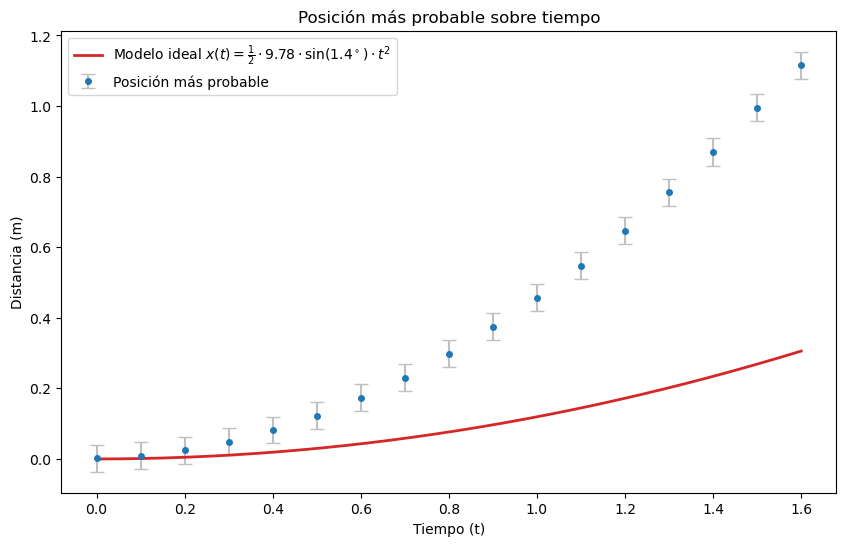

In [16]:
# Modelo ideal corregido: x(t) = 1/2 * 9.78 * sin(5°) * t^2
t_model = np.linspace(summary_df['t'].min(), summary_df['t'].max(), 500)
x_model = 0.5 * g * np.sin(theta_rad) * t_model**2

plt.figure(figsize=(10, 6))

# x vs t con SEM
plt.errorbar(summary_df['t'], summary_df['x_mean'], yerr=summary_df['sem_magnitude'],
             fmt='o', capsize=5, label='Posición más probable', color='tab:blue', markersize=4, ecolor='silver')

# Modelo ideal
plt.plot(t_model, x_model,
         label=fr'Modelo ideal $x(t) = \frac{{1}}{{2}} \cdot 9.78 \cdot \sin({theta_deg}^\circ) \cdot t^2$',
         color='tab:red', linewidth=2)

plt.xlabel('Tiempo (t)')
plt.ylabel('Distancia (m)')
plt.title('Posición más probable sobre tiempo')
plt.legend()
plt.show()

In [17]:
# Modelo teórico
summary_df['x_model'] = 0.5 * g * np.sin(theta_rad) * summary_df['t']**2

# Residuales
summary_df['residual'] = summary_df['x_mean'] - summary_df['x_model']

# MAE y RMSE
mae = summary_df['residual'].abs().mean()
rmse = np.sqrt((summary_df['residual']**2).mean())

# Z-score experimental (residual normalizado)
summary_df['z_score'] = summary_df['residual'] / summary_df['sem_magnitude']

# Porcentaje de puntos dentro de 1σ y 2σ
within_1sigma = (summary_df['z_score'].abs() <= 1).mean() * 100
within_2sigma = (summary_df['z_score'].abs() <= 2).mean() * 100

# Desviación estándar de los z-scores
z_score_std = summary_df['z_score'].std(ddof=1)

# Mostrar resultados
print("Evaluación experimental del modelo ideal:")
print(f"✔ MAE (Error Absoluto Medio): {mae:.6f} m")
print(f"✔ RMSE (Error Cuadrático Medio): {rmse:.6f} m")
print(f"✔ % de puntos dentro de 1σ: {within_1sigma:.1f}%")
print(f"✔ % de puntos dentro de 2σ: {within_2sigma:.1f}%")
print(f"✔ Desviación estándar de z-scores: {z_score_std:.3f}")

Evaluación experimental del modelo ideal:
✔ MAE (Error Absoluto Medio): 0.292185 m
✔ RMSE (Error Cuadrático Medio): 0.389895 m
✔ % de puntos dentro de 1σ: 23.5%
✔ % de puntos dentro de 2σ: 29.4%
✔ Desviación estándar de z-scores: 6.816


In [18]:
# Evaluación experimental del modelo ideal:
# ✔ MAE (Error Absoluto Medio): 0.023399 m
# ✔ RMSE (Error Cuadrático Medio): 0.026605 m
# ✔ % de puntos dentro de 1σ: 97.0%
# ✔ % de puntos dentro de 2σ: 100.0%
# ✔ Desviación estándar de z-scores: 0.619

In [19]:
# Evaluación experimental del modelo ideal:
# ✔ MAE (Error Absoluto Medio): 0.019969 m
# ✔ RMSE (Error Cuadrático Medio): 0.021778 m
# ✔ % de puntos dentro de 1σ: 100.0%
# ✔ % de puntos dentro de 2σ: 100.0%
# ✔ Desviación estándar de z-scores: 0.385

In [20]:
# Evaluación experimental del modelo ideal:
# ✔ MAE (Error Absoluto Medio): 0.009849 m
# ✔ RMSE (Error Cuadrático Medio): 0.011091 m
# ✔ % de puntos dentro de 1σ: 100.0%
# ✔ % de puntos dentro de 2σ: 100.0%
# ✔ Desviación estándar de z-scores: 0.220